In [2]:
import numpy as np

import matplotlib as mpl

from IPython.display import clear_output
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image

In [3]:
import pandas as pd

In [4]:
import tensorflow as tf
from tensorflow import keras

In [5]:
import glob, os 
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
path="E:\Python_Training\Kaggle\Pollen_bee_classification\honey-bee-pollen\PollenDataset\images"

imlist= glob.glob(os.path.join(path, '*.jpg'))

# Data import

In [6]:
def dataset(file_list,size=(300,180),flattened=False):
	data = []
	for i, file in enumerate(file_list):
		image = io.imread(file)
		image = transform.resize(image, size, mode='constant')
		if flattened:
			image = image.flatten()

		data.append(image)

	labels = [1 if f.split("\\")[-1][0] == 'P' else 0 for f in file_list]

	return np.array(data), np.array(labels)

In [7]:
X,y=dataset(imlist)

## Normalizing data

In [266]:
X=X-X.mean()

In [267]:
X.max()

0.7000380205483308

In [268]:
X.min()

-0.2999619794516693

In [269]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)

In [270]:
print('The length of X: ',len(X))  # data
print('The shape of X: ',X.shape)  # target
print('The shape of Y', y.shape)


The length of X:  714
The shape of X:  (714, 300, 180, 3)
The shape of Y (714,)


In [271]:
img=imlist[0]

In [272]:
img

'E:\\Python_Training\\Kaggle\\Pollen_bee_classification\\honey-bee-pollen\\PollenDataset\\images\\NP10057-126r.jpg'

In [273]:
img.split("\\")

['E:',
 'Python_Training',
 'Kaggle',
 'Pollen_bee_classification',
 'honey-bee-pollen',
 'PollenDataset',
 'images',
 'NP10057-126r.jpg']

In [274]:
img.split("\\")[-1][0]

'N'

In [275]:
def show(img):
  plt.figure(figsize=(12,12))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img)
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


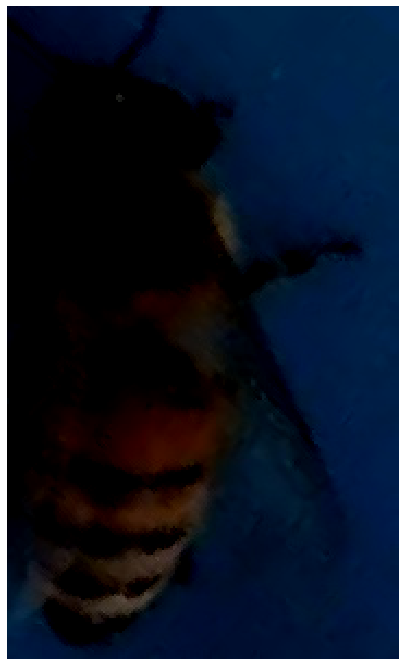

In [276]:
show(X[5])

# Dimensionality reduction

In [277]:
# Dimensionality reduction to avaid OOM error (running on 3GB GPU)
max_pool = keras.layers.MaxPool2D(pool_size=2)

def batch_dim_red(X):
    for i in range(1,int(X.shape[0]/100)+2):
        Xt=X[(i-1)*100:i*100]
        Xt=max_pool(Xt)
        if i==1:
            X_red=Xt
        else:
            X_red=tf.concat([ X_red, Xt], 0)
    return np.asarray(X_red)

In [278]:
X_red=batch_dim_red(X)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [279]:
y.sum()/y.shape[0]

0.5168067226890757

In [280]:
X_red.shape

(714, 150, 90, 3)

In [281]:
n=len(X)

In [282]:
n_train=int(n*0.6)
n_val=int(0.2*n)

In [283]:
X_train, X_val, X_test=X_red[:n_train],X_red[n_train:(1-n_val)], X_red[(1-n_val):]
y_train, y_val, y_test=y[:n_train],y[n_train:(1-n_val)], y[(1-n_val):]

In [284]:
X_train.shape

(428, 150, 90, 3)

In [285]:
X_val.shape

(145, 150, 90, 3)

In [286]:
y.sum()

369

In [287]:
X_test.shape

(141, 150, 90, 3)

In [288]:

from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=3, input_shape=[150, 90, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

In [289]:

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 150, 90, 64)       1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 45, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 75, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 37, 22, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 37, 22, 128)       73856     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 37, 22, 128)       147584    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 18, 11, 128)      

In [290]:
model.compile(loss='binary_crossentropy', optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=50, validation_data=[X_val, y_val], batch_size=15)


Train on 428 samples, validate on 145 samples
Epoch 1/50
428/428 [==============================] - 6s 14ms/sample - loss: 0.7059 - accuracy: 0.5304 - val_loss: 1.2873 - val_accuracy: 0.5103
Epoch 2/50
428/428 [==============================] - 1s 2ms/sample - loss: 0.7398 - accuracy: 0.6893 - val_loss: 0.5299 - val_accuracy: 0.8759
Epoch 3/50
428/428 [==============================] - 1s 2ms/sample - loss: 0.3919 - accuracy: 0.8551 - val_loss: 0.2436 - val_accuracy: 0.9103
Epoch 4/50
428/428 [==============================] - 1s 2ms/sample - loss: 0.1860 - accuracy: 0.9369 - val_loss: 0.2785 - val_accuracy: 0.9034
Epoch 5/50
428/428 [==============================] - 1s 2ms/sample - loss: 0.1200 - accuracy: 0.9533 - val_loss: 0.2109 - val_accuracy: 0.9379
Epoch 6/50
428/428 [==============================] - 1s 2ms/sample - loss: 0.0769 - accuracy: 0.9766 - val_loss: 0.3268 - val_accuracy: 0.9241
Epoch 7/50
428/428 [==============================] - 1s 2ms/sample - loss: 0.0559 - accu

In [230]:
score = model.evaluate(X_test, y_test)

141/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [291]:
X_new = X_test[:100]

In [292]:
y_pred = model.predict(X_new)

In [293]:
y_pred.shape


(100, 1)

In [294]:
y_pred=np.around(y_pred)

In [295]:
y_pred.sum()

53.0

In [296]:
y_test[:100].sum()

53

In [297]:
y_base=y_test[:100].reshape((len(y_test[:100]),1))

In [298]:
(y_base==y_pred).sum()

96

# Data Augmentation

In [363]:
from sklearn.model_selection import train_test_split

In [364]:
X_red_train, X_red_test, y_train, y_test=train_test_split(X_red, y, test_size=0.2, random_state=42)

In [365]:
X_red_train.shape

(571, 150, 90, 3)

## Flipping left to right

In [334]:
img=X_red[:3]

In [335]:
type(img)

numpy.ndarray

In [336]:
img_flip=tf.image.random_flip_left_right(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


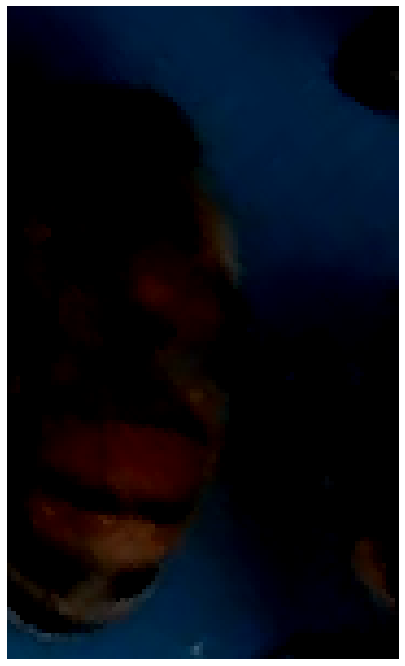

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


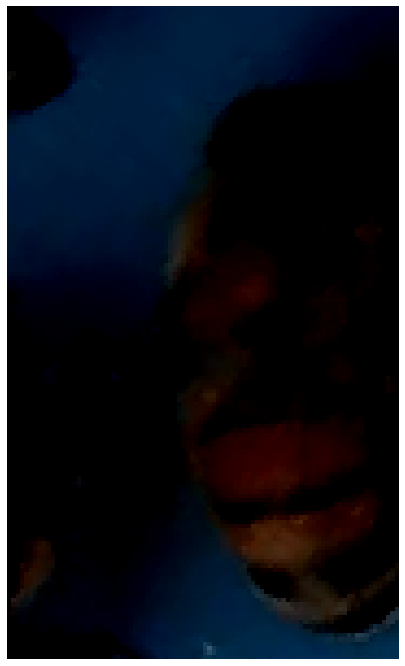

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


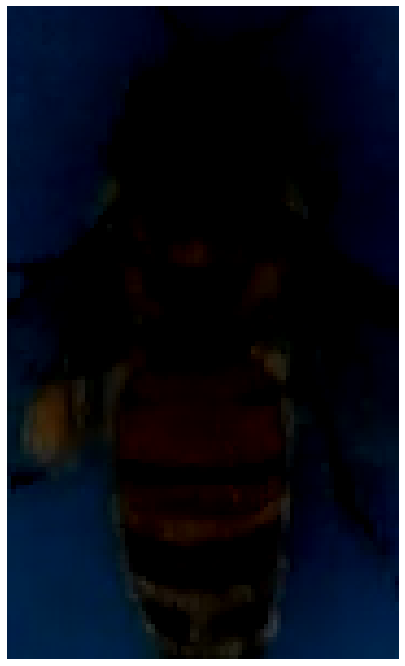

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


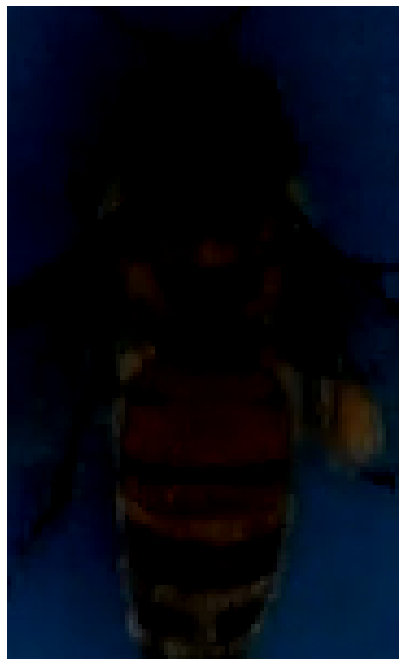

In [337]:
for i in range(0,2):
    img_flip=tf.image.flip_left_right(img[i])
    show(img_flip)
    show(img[i])

## Flipping up and down

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


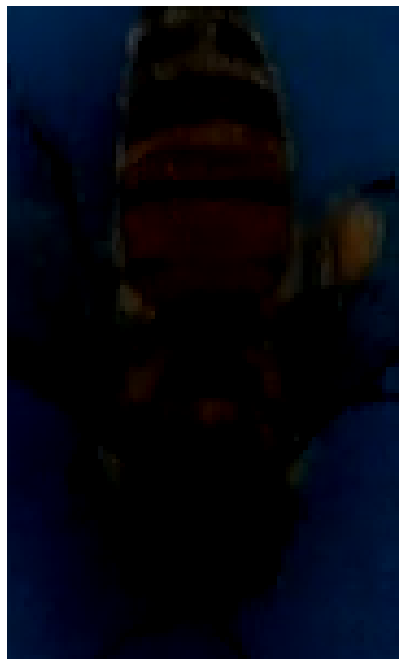

In [338]:
img_flip2=tf.image.flip_up_down(img[1])
show(img_flip2)

## Random shift

In [339]:
img_shift=tf.keras.preprocessing.image.random_shift(
    img[0],
    0.2,
    0.2,
    row_axis=0,
    col_axis=1,
    channel_axis=2,
    fill_mode='nearest',
    cval=0
    
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


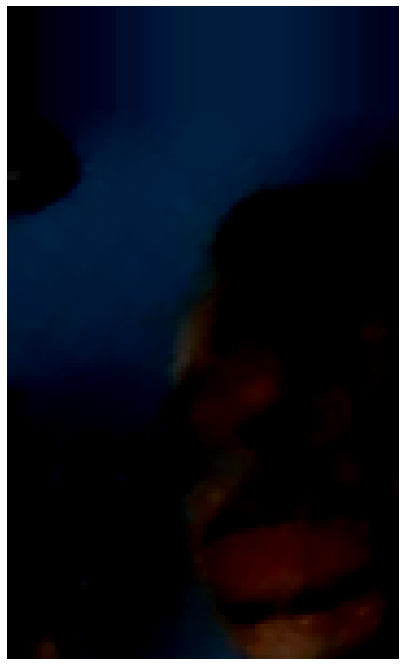

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


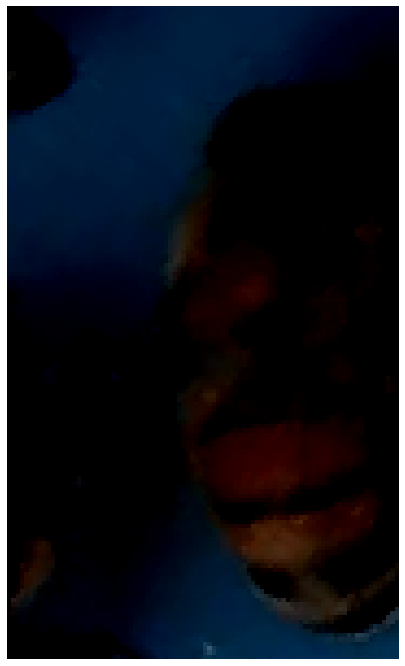

In [340]:
show(img_shift)
show(img[0])

In [366]:
def augment_flip(X):
    y_aug=[]
    for i in range(0,int(X.shape[0])):
        X_flipv=tf.image.flip_left_right(X[i])
        X_fliph=tf.image.flip_up_down(X[i])
        X_aug_stack=np.stack((X_flipv,X_fliph))
        y_aug.append(y[i])
        y_aug.append(y[i])
        if i==0:
            X_aug=X_aug_stack
        else:
            X_aug=tf.concat([X_aug, X_aug_stack], 0)
    return [np.asarray(X_aug), np.asarray(y_aug)]

In [367]:
X_aug,y_aug=augment_flip(X_red_train)

In [368]:
X_red_train.shape

(571, 150, 90, 3)

In [369]:
X_aug.shape

(1142, 150, 90, 3)

In [370]:
X_aug=np.asarray(tf.concat([X_red, X_aug],0))

In [371]:
y_aug=np.asarray(tf.concat([y, y_aug],0))

In [372]:
X_aug.shape

(1856, 150, 90, 3)

In [373]:
y_aug.shape

(1856,)

In [349]:
def augment_shift(X,y):
    y_aug=[]
    for i in range(0,int(X.shape[0])):
        X_shift=tf.keras.preprocessing.image.random_shift(
            X[i],
            0.2,
            0.2,
            row_axis=0,
            col_axis=1,
            channel_axis=2,
            fill_mode='constant',
            cval=0

        )
        X_shift=X_shift.reshape((1,150, 90, 3))
        y_aug.append(y[i])
        
        if i==0:
            X_aug=X_shift
        else:
            X_aug=tf.concat([X_aug, X_shift], 0)
            
    return [np.asarray(X_aug), np.asarray(y_aug)]

In [350]:
X_shift,y_shift=augment_shift(X_aug, y_aug)
X_shift.shape

(1856, 150, 90, 3)

In [351]:
y_shift.shape

(1856,)

In [352]:
X_enriched=np.asarray(tf.concat([X_aug, X_shift], 0))

In [353]:
X_enriched.shape

(3712, 150, 90, 3)

In [354]:
y_enriched=np.asarray(tf.concat([y_aug, y_shift], 0))

In [355]:
y_enriched.shape

(3712,)

In [374]:
X_train, X_valid, y_train, y_valid=train_test_split(X_aug, y_aug, test_size=0.25, random_state=42)

In [375]:
X_train.shape

(1392, 150, 90, 3)

In [376]:
y_train.shape

(1392,)

# Training model on enriched data

In [377]:

from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model2 = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=3, input_shape=[150, 90, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer="nadam", metrics=["accuracy"])
history = model2.fit(X_train, y_train, epochs=50, validation_data=[X_valid, y_valid], batch_size=15)


Train on 1392 samples, validate on 464 samples
Epoch 1/50
1035/1392 [=====================>........] - ETA: 1s - loss: 0.6932 - accuracy: 0.5063

In [ ]:
score = model2.evaluate(X_test, y_test)